In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os
import struct
import numpy as np




In [3]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

In [4]:

def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte'
                               % kind)
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II',
                                 lbpath.read(8))
        labels = np.fromfile(lbpath,
                             dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack('>IIII',
                                               imgpath.read(16))
        images = np.fromfile(imgpath,
                             dtype=np.uint8).reshape((len(labels),28,28))

    return images, labels

In [5]:
X_train, y_train = load_mnist('./data')
                              
X_test, y_test = load_mnist('./data',kind='t10k')
print(X_test.shape,y_test.shape)

(10000, 28, 28) (10000,)


In [6]:
def img_show(img):
    plt.figure(figsize=(1,1))
    plt.imshow(img,cmap='Greys',interpolation='nearest')
    

In [7]:
def imgs_show(imgs,row,col):
    fig,ax = plt.subplots(nrows=row,ncols=col,sharex=True,sharey=True)
    ax = ax.flatten()
    for i in range(row*col):
        img = imgs[i]
        ax[i].imshow(img,cmap='Greys', interpolation='nearest')
    
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    plt.tight_layout()
    plt.show()
    
    

In [8]:
def normal_minist(img):
    return (img / 255.0) -0.5

In [9]:
def expend_HWC(img):
    return np.expand_dims(img,axis=3)


In [10]:
def to_CHW(img):
    return np.transpose(img,(0,3,1,2))
def to_HWC(img):
    return np.transpose(img,(0,2,3,1))

In [11]:
#只能运行一次
X_train_nor = expend_HWC(X_train)
X_train_nor = normal_minist(X_train_nor)
X_train_nor = to_CHW(X_train_nor)
print(X_train_nor.shape)

X_test_nor = expend_HWC(X_test)
X_test_nor = normal_minist(X_test_nor)
X_test_nor = to_CHW(X_test_nor)
print(X_test_nor.shape)




(60000, 1, 28, 28)
(10000, 1, 28, 28)


In [12]:
eval_index = 0


In [13]:

test_postitive = X_test_nor[y_test == eval_index]
test_nagivate = X_test_nor[y_test != eval_index]
print(test_postitive.shape)
print(test_nagivate.shape)


train_positive = X_train_nor[y_train == eval_index][[0,55,1111,1009,327,128,5000,469,2000,3001]]
# imgs_show(train_positive,2,5)
# train_nagivate = np.concatenate((train_1 , train_2 ,train_3 , train_4 ,train_5 ,
#                                  train_6 , train_7 ,train_8 ,train_9)) 
train_nagivate = X_train_nor[y_train != eval_index]

print(train_nagivate.shape)
print(train_positive.shape)

# imgs_show(train_nagivate[:25],5,5)



(980, 1, 28, 28)
(9020, 1, 28, 28)
(54077, 1, 28, 28)
(10, 1, 28, 28)


In [14]:
shuf_index = np.random.permutation(len(train_nagivate))

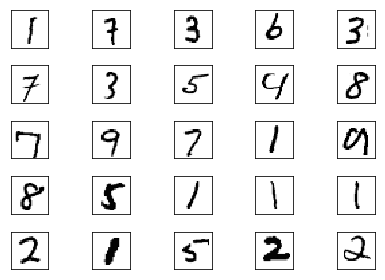

[-0.5        -0.5        -0.5        -0.5        -0.5        -0.5
 -0.5        -0.5        -0.5        -0.44509804 -0.49607843  0.10392157
  0.49215686 -0.14705882 -0.5        -0.5        -0.5        -0.5
 -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
 -0.5        -0.5        -0.5        -0.5       ]


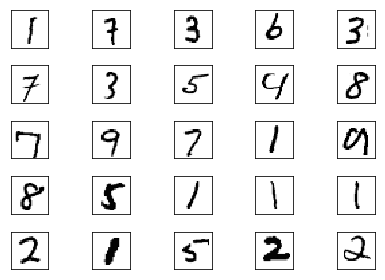

[  0   0   0   0   0   0   0   0   0  14   1 154 253  90   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]


In [15]:
# print(train_positive[0][0])
imgs_show(np.squeeze (train_nagivate[50000:50025]),5,5)
print(train_nagivate[0][0][10])

imgs_show(X_train[y_train != eval_index][50000:50025],5,5)
print(X_train[y_train != eval_index][0][10])


In [16]:
def num_flat_features(x):
    size = x.size()[1:]
    num_features =1
        
    for s in size:
        num_features *= s
    return num_features
        

In [40]:
class AutoCodeNet(nn.Module):
    def __init__(self):
        super(AutoCodeNet,self).__init__()
        self.conv1 = nn.Conv2d(1,16,kernel_size=3,stride=1,padding=1)
        self.pool1 = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(16,8,kernel_size=3,stride=1,padding=1)
        self.pool2 = nn.MaxPool2d(2,2)
        self.conv3 = nn.Conv2d(8,8,kernel_size=3,stride=1,padding=1)
        self.pool3 = nn.MaxPool2d(2,2,padding=1)
      
            
        
        self.up1 = nn.Upsample(scale_factor = 2,mode='nearest')
        self.conv_d1 = nn.Conv2d(8,8,kernel_size=3,stride=1,padding=1)
        self.up2 = nn.Upsample(scale_factor = 2)
        self.conv_d2 = nn.Conv2d(8,8,kernel_size=3,stride=1)
        self.up3 = nn.Upsample(scale_factor = 2)
        self.conv_d3 = nn.Conv2d(8,16,kernel_size=3,stride=1,padding=1)
        
        self.conv_d4 = nn.Conv2d(16,1,kernel_size=3,stride=1,padding=1)
        
        self.features={}
        
    def decodeForward(self,x):
        x = F.relu(self.conv1(x))
        self.features['relu1'] = x
        x = self.pool1(x)
        self.features['pool1'] = x
        
        x = F.relu(self.conv2(x))
        self.features['relu2'] = x
        x = self.pool2(x)
        self.features['pool2'] = x
        
        x = F.relu(self.conv3(x))
        self.features['relu3'] = x
        x = self.pool3(x)
        self.features['pool3'] = x
        return x
    
    def encodeforward(self,x):
        
        x = self.up1(x)
        self.features['up1'] = x
        x = F.relu(self.conv_d1(x))
        self.features['relu_d1'] = x
        
        x = self.up2(x)
        self.features['up2'] = x
        x = F.relu(self.conv_d2(x))
        self.features['relu_d2'] = x
        
        x = self.up3(x)
        self.features['up3'] = x
        x = F.relu(self.conv_d3(x))
        self.features['relu_d3'] = x
        
        x = self.conv_d4(x)
        self.features['conv_d4'] = x
        
        x = F.tanh(x)
        self.features['tanh'] = x
        return x
        
    def forward(self,x):
        #decode
        x = F.relu(self.conv1(x))
        self.features['relu1'] = x
        x = self.pool1(x)
        self.features['pool1'] = x
        
        x = F.relu(self.conv2(x))
        self.features['relu2'] = x
        x = self.pool2(x)
        self.features['pool2'] = x
        
        x = F.relu(self.conv3(x))
        self.features['relu3'] = x
        x = self.pool3(x)
        self.features['pool3'] = x
        
        
        #encode
        
        x = self.up1(x)
        self.features['up1'] = x
        x = F.relu(self.conv_d1(x))
        self.features['relu_d1'] = x
        
        x = self.up2(x)
        self.features['up2'] = x
        x = F.relu(self.conv_d2(x))
        self.features['relu_d2'] = x
        
        x = self.up3(x)
        self.features['up3'] = x
        x = F.relu(self.conv_d3(x))
        self.features['relu_d3'] = x
        
        x = self.conv_d4(x)
        self.features['conv_d4'] = x
        
        x = F.tanh(x)
        self.features['tanh'] = x
        return x
        
        
        
        
        
        
        

In [41]:
net_auto = AutoCodeNet()
# print(net_auto)
inp1 = Variable(torch.randn((1,1,28,28)))

middle = net_auto.decodeForward(inp1)
print(middle.size())

out = net_auto.encodeforward(middle)
print(out.size())
# print(net_auto.features['relu1'].size())
# print(net_auto.features['pool1'].size())
# print(net_auto.features['relu2'].size())
# print(net_auto.features['pool2'].size())
# print(net_auto.features['relu3'].size())
# print(net_auto.features['pool3'].size())

# print("encode:")
# print(net_auto.features['up1'].size())
# print(net_auto.features['relu_d1'].size())
# print(net_auto.features['up2'].size())
# print(net_auto.features['relu_d2'].size())
# print(net_auto.features['up3'].size())
# print(net_auto.features['relu_d3'].size())
# print(net_auto.features['conv_d4'].size())
# print(net_auto.features['tanh'].size())



torch.Size([1, 8, 4, 4])
torch.Size([1, 1, 28, 28])


In [42]:
def getnext(train_x,train_y,batch_size):
    batchs = len(train_y) // batch_size
    print(len(train_y),batchs)

    for i in range(batchs):
        x = train_x[batch_size * i : batch_size * (i+1)]
        y = train_y[batch_size * i : batch_size * (i+1)]
        yield x,y
        

In [43]:
def get_nagivate_next(train_positive,train_nagivate):
    batch_size = len(train_positive)
    batchs = len(train_nagivate) // batch_size
    print(len(train_nagivate),batchs)
    
    for i in range(batchs):
        x = np.concatenate((train_positive,train_nagivate[batch_size * i : batch_size * (i+1)]))
        y = np.concatenate((np.zeros(batch_size),np.ones(batch_size)))
        shuf_index = np.random.permutation(len(y))
        x = x[shuf_index]
        y = y[shuf_index]
        
        
        yield x ,y 
        

10 1
(20, 1, 28, 28)
[0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1.]


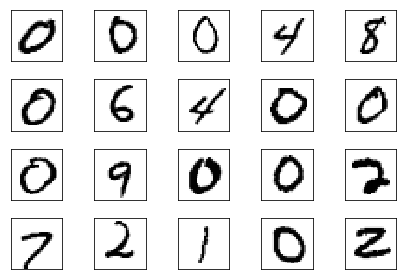

In [44]:
datas = get_nagivate_next(train_positive,train_nagivate[100:110])
for x,y in datas:
    print(x.shape)
    
    print(y)
    imgs_show(np.squeeze( x),4,5)


In [52]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(666)
device = torch.device("cuda" if use_cuda else "cpu")
net_auto.to(device)
# net_auto.double()


criterion = nn.MSELoss()
optimizer = optim.SGD(net_auto.parameters(),lr=0.001,momentum=0.9)


In [54]:
net_auto.train()
for epoch in range(40):
    datas = get_nagivate_next(train_positive,train_nagivate)
    trainloss = 0
    
    for x,y in datas:
        inputs, labels = Variable(torch.from_numpy(x)).to(device), Variable(torch.from_numpy(y).long()).to(device)
#         print(labels)
        optimizer.zero_grad()
        output = net_auto(inputs)
#         print(output.size())
        loss = criterion(output,inputs)
        trainloss += loss.item()
        loss.backward()
        optimizer.step()
        
    print('%d  loss: %.3f' % (epoch ,  trainloss))
torch.save(net_auto,'model_autoEncode.pkl')

54077 5407
0  loss: 338.164
54077 5407
1  loss: 205.836
54077 5407
2  loss: 170.967
54077 5407
3  loss: 150.637
54077 5407
4  loss: 137.348
54077 5407
5  loss: 127.933
54077 5407
6  loss: 120.787
54077 5407
7  loss: 114.564
54077 5407
8  loss: 109.539
54077 5407
9  loss: 105.764
54077 5407
10  loss: 102.568
54077 5407
11  loss: 99.789
54077 5407
12  loss: 97.333
54077 5407
13  loss: 95.105
54077 5407
14  loss: 93.068
54077 5407
15  loss: 91.208
54077 5407
16  loss: 89.507
54077 5407
17  loss: 87.947
54077 5407
18  loss: 86.518
54077 5407
19  loss: 85.256
54077 5407
20  loss: 84.081
54077 5407
21  loss: 82.994
54077 5407
22  loss: 82.002
54077 5407
23  loss: 81.077
54077 5407
24  loss: 80.217
54077 5407
25  loss: 79.406
54077 5407
26  loss: 78.636
54077 5407
27  loss: 77.902
54077 5407
28  loss: 77.203
54077 5407
29  loss: 76.554
54077 5407
30  loss: 75.948
54077 5407
31  loss: 75.356
54077 5407
32  loss: 74.745
54077 5407
33  loss: 74.125
54077 5407
34  loss: 73.545
54077 5407
35  loss

C:\Program Files\Anaconda3\lib\site-packages\torch\serialization.py:193: UserWarning: Couldn't retrieve source code for container of type AutoCodeNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [53]:
net_auto = torch.load('model_autoEncode.pkl')
net_auto.to(device)
net_auto.eval()


with torch.no_grad():
    inputs1,inputs2 = Variable(torch.from_numpy( train_positive[1:2])).to(device), \
        Variable(torch.from_numpy( X_train_nor[y_train==8][25:26])).to(device)
#     outputs = net_auto(inputs)
#     img_show(np.squeeze(outputs.data))
    
    middle1 = net_auto.decodeForward(inputs1)
    middle2 = net_auto.decodeForward(inputs2)
    print(middle1.data[:,5,0,0])
    print(middle2.data[:,4,0,0])
    
    middle1.data[:,5,0,0] = middle1.data[:,5,0,0]+ 0.1
    
    print(middle1.data[:,5,0,0])
    print(middle2.data[:,5,0,0])

    out = net_auto.encodeforward(middle1)
    print(out.size())
    img_show(np.squeeze(out.data))
    img_show(np.squeeze(inputs2))
    img_show(np.squeeze(inputs1))
#     imgs_show(np.squeeze(train_nagivate[:10]),2,5)
    
#     print(outputs.data[1][0][10])
#     print(train_nagivate[1][0][10])
    

UnicodeDecodeError: 'ascii' codec can't decode byte 0xc3 in position 1081: ordinal not in range(128)

In [ ]:
upconv = nn.ConvTranspose2d(21,10,5,stride=2,padding=1)
print(upconv.weight.size())
print(upconv.bias.size())
# copy_index = [0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
# upconv.weight.data = down.weight.data[copy_index]